## 1. Packages

In [1]:
''' root '''
import os
os.chdir("/scratch/kll482/cathay")
print("Current Working Directory:", os.getcwd())

import sys
sys.path.append("/scratch/kll482/cathay/")

''' config '''
from configparser import ConfigParser
config = ConfigParser()
config.read("config/config.ini")
print("Config Sections:", config.sections())
args = config["graph_models"]

Current Working Directory: /scratch/kll482/cathay
Config Sections: ['text_cleaning', 'feature_engineering', 'graph_models']


In [2]:
# ''' packages '''
# import torch, torchvision
# import pandas as pd, numpy as np
# import argparse
# import torch
# import torch.nn.functional as F
# from torch import nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.utils.data import random_split
# # from torch_geometric.data.InMemoryDataset import collate
# from tqdm import tqdm_notebook as tqdm
# from sklearn.utils import shuffle
# from sklearn.metrics import confusion_matrix, classification_report
# from src.preprocessing.feature_engineering.bert_embedding import BertEmbedding
# import multiprocessing as mp

# import time
# from datetime import datetime
# import matplotlib.pyplot as plt
# import seaborn as sns

In [3]:
''' packages '''
# 1. models
import torch, torchvision
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 2. others
from tqdm import tqdm_notebook as tqdm
import multiprocessing as mp
import argparse
import pandas as pd, numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("logs/graph/")

# 3. custom
from src.preprocessing.feature_engineering.bert_embedding import BertEmbedding
from src.utils.vocabulary import Vocabulary
from src.utils.pipeline import Pipe

## 2.1. Initial Variables & Parameters

In [4]:
''' Hyperparameters '''
parser = {
    "batch_size": 64,
    "seed": 5, # random seed
    "epochs": 5,
    "cuda": True, # use cuda or not
    "log_every": 100,
    "lr": 0.01,  # initial learning rate
    "lr_decay": 0.7,  # decay lr when not observing improvement in val_loss
    "lr_min": 1e-5,  # stop when lr is too low
    "n_bad_loss": 4,  # number of bad val_loss before decaying
    "clip": 2.3,
    "result_path": "result/sequence/",  # path to save models
    "log_path": "logs/sequence/",
}
config = argparse.Namespace(**parser)

In [5]:
''' General '''
config.USE_CUDA = 1 # bool(int(args["use_cuda"]))
config.SEED = int(args["set_seed"])
config.MODELING_FEATURE_PATH = args["modeling_feature_path"]
config.DATA_PATH = args["data_path"]
config.NUM_FEATURES = 768
config.N_CLASSES = 1
config.TARGET = "overall"
config.TOKENS = "reviewTokens"

## 2.2. CUDA Settings

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config.USE_CUDA = config.USE_CUDA and torch.cuda.is_available()
print("cuda on: ", config.USE_CUDA)
if config.USE_CUDA:
    torch.cuda.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
else:
    torch.manual_seed(config.SEED)
    
device = torch.device("cuda:0" if config.USE_CUDA else "cpu")

cuda on:  True


In [7]:
def seed_torch(seed=config.SEED):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 3-1. Data

In [8]:
print("read the datasets...")
files = []
# file_path = [file for file in os.listdir(config.DATA_PATH) if file.endswith(".json")]
file_path = ['Video_Games_5.json', 'Musical_Instruments_5.json']
# file_path = ['Musical_Instruments_5.json']
for file in file_path:    
    files.append(pd.read_json(os.path.join(config.DATA_PATH, file)))
    
df = pd.concat(files)

read the datasets...


In [9]:
print(df.shape)
df.head(3)

(727329, 7)


,overall,reviewText,reviewTokens,uniqueTokens,edgeIndex3,edgeIndex5,edgeIndex10
0,5,"This game is a bit hard to get the hang of, bu...","[game, bit, hard, get, hang, great]","[great, get, hard, game, hang, bit]","[[3, 5, 3, 2, 3, 1, 5, 3, 5, 2, 5, 1, 5, 4, 2,...","[[3, 5, 3, 2, 3, 1, 3, 4, 3, 0, 5, 3, 5, 2, 5,...","[[3, 5, 3, 2, 3, 1, 3, 4, 3, 0, 5, 3, 5, 2, 5,..."
1,4,I played it a while but it was alright. The st...,"[play, alright, steam, bit, trouble, move, gam...","[way, hard, activate, anno, alright, fun, game...","[[18, 4, 18, 11, 18, 12, 4, 18, 4, 11, 4, 12, ...","[[18, 4, 18, 11, 18, 12, 18, 15, 18, 14, 4, 18...","[[18, 4, 18, 11, 18, 12, 18, 15, 18, 14, 18, 6..."
2,3,ok game.,"[ok, game]","[ok, game]","[[0, 1, 1, 0], [1, 0, 0, 1]]","[[0, 1, 1, 0], [1, 0, 0, 1]]","[[0, 1, 1, 0], [1, 0, 0, 1]]"


Let's take a look at the length of review tokens.

In [57]:
review_len = [len(row) for row in df["uniqueTokens"]]
print("max:", max(review_len))
print("min:", min(review_len))
print("median:", np.median(review_len))
print("mean:", np.mean(review_len))
print("Q3:", np.quantile(review_len, 0.75))
print("Q1:", np.quantile(review_len, 0.25))
print("Q(90%):", np.quantile(review_len, 0.9))

max: 1233
min: 1
median: 16.0
mean: 37.81206854119662
Q3: 43.0
Q1: 6.0
Q(90%): 98.0


Text(0, 0.5, 'Count')

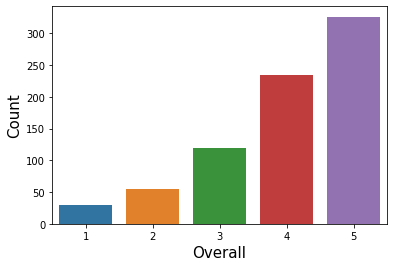

In [92]:
sns.countplot(df.iloc[[i for i, v in enumerate(df["reviewTokens"]) if len(v) > 1000]]["overall"])
plt.xlabel("Overall", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

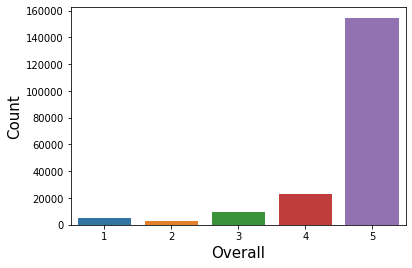

In [97]:
sns.countplot(df.iloc[[i for i, v in enumerate(df["reviewTokens"]) if len(v) <= 6]]["overall"])
plt.xlabel("Overall", fontsize=15)
plt.ylabel("Count", fontsize=15)

In [98]:
short_selected_index = [i for i, v in enumerate(df["reviewTokens"]) if len(v) < 2]
print(len(short_selected_index))
df.iloc[short_selected_index, :]["reviewText"]

49423


47                     Awesome
104                     Great!
108                 Very nice!
126                       good
129                      GREAT
                  ...         
230929          Worked for me!
230933    Works how it should.
230951             Very good !
230967                Solid...
230974                      ok
Name: reviewText, Length: 49423, dtype: object

In [99]:
short_selected_index = [i for i, v in enumerate(df["reviewTokens"]) if len(v) > 1000]
print(len(short_selected_index))
df.iloc[short_selected_index, :]["reviewText"]

765


885       Every once in a while I experience a piece of ...
1160      Back in the late 1990s I wrote two articles fo...
1492      I'm pretty sick and tired of people calling Su...
3116      Yes, you heard me. Final Fantasy VII...\n...is...
4674      I was getting tired of Microsoft Combat Flight...
                                ...                        
168195    I bought this for a guitar amp and vocal PA be...
174470    I first became interested in buying Komplete f...
197799    I'm shocked at how difficult it was to figure ...
218907    After my previous experiences with this amp (R...
224448    If a pedal's introduction at NAMM includes a d...
Name: reviewText, Length: 765, dtype: object

In [77]:
["reviewText"][222652])

222652    Dragon Age: Origins Ultimate Edition\n1. Origi...
222652    I bought these for an almost vintage 1990 Gibs...
Name: reviewText, dtype: object


<AxesSubplot:>

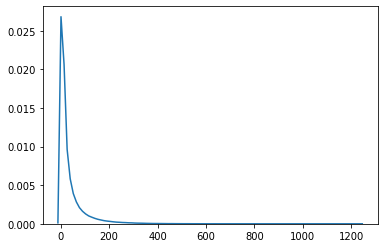

In [11]:
word_len = [len(row) for row in df["uniqueTokens"]]
sns.distplot(word_len, hist=False)

## 3-2. Review Score to Positive/Negative

In [12]:
def reclassify(df, target="overall"):
    '''
    1. score 3 & 4 & 5 -> 1 (positive)
    2. score 1 & 2 -> 0 (negative)
    '''
    y = []
    for gp in df[target]:
        if gp in [3, 4, 5]:
            y.append(1)
        elif gp in [1, 2]:
            y.append(0)
    assert len(y) == df.shape[0]
    
    return y

In [13]:
df["y"] = reclassify(df, "overall")
config.TARGET = "y"

## 3-3. Train Test Split

In [14]:
def dataset_split(df, train_percent=0.8, val_percent=0.1, set_seed=config.SEED):
    n = df.shape[0] # get length of dataframe

    # I will set the percentage of validation and test sets to be both 0.1
    train_index, rest_index = train_test_split(range(n), train_size=0.8, random_state=config.SEED)
    val_index, test_index = train_test_split(rest_index, train_size=(val_percent/(1-train_percent)), random_state=config.SEED) # 0.1/(1-0.8) = 0.1/0.2 = 0.5

    # check if there is any intersection among all three sets
    assert len(set(train_index + val_index + test_index)) == n

    # get sub_datasets by random_split
    np.random.seed(config.SEED)
    train_df, val_df, test_df = df.iloc[train_index, :].reset_index(drop=True),\
                                df.iloc[val_index, :].reset_index(drop=True),\
                                df.iloc[test_index, :].reset_index(drop=True)

    # check random_split works correctly
    assert (len(train_df)+len(val_df)+len(test_df)) == n
    
    return train_df, val_df, test_df

In [15]:
train_df, val_df, test_df = dataset_split(df)

## 3-4. Build Vocabulary

It's reasonable to build a vocabulary list from only the training set.

In [16]:
vocabulary = Vocabulary()

for row in train_df[config.TOKENS]:
    for word in row:
        vocabulary.add_word(word)

## 3-5. Imbalanced Dataset

Note: I only make the training set balanced and leave the validation and test sets alone.

<AxesSubplot:xlabel='y', ylabel='count'>

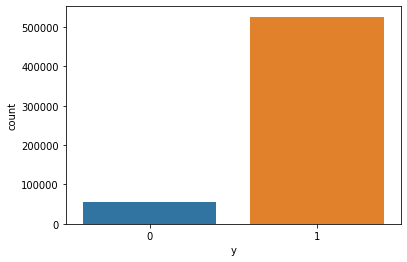

In [17]:
# plot the imbalanced target variable
sns.countplot(train_df[config.TARGET])

In [18]:
# undersampling
def undersampling(df, target=config.TARGET, set_seed=config.SEED):
    np.random.seed(set_seed)
    df = df.groupby(target)
    df = df.apply(lambda x: x.sample(df.size().min())).sample(frac=1).reset_index(drop=True)
    return df

In [19]:
train_df = undersampling(train_df)
print("Length of training set:", train_df.shape[0])
print("Length of test set:", test_df.shape[0])

Length of training set: 111520
Length of test set: 72733


## 4-1. Dataset

In [20]:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html
class ReviewDataset(Dataset):
    def __init__(self, config, df, use_cuda, embeddings):
        self.df = df
        self.use_cuda = use_cuda
        self.embeddings = embeddings
        self.config = config
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        tt = torch.cuda if self.use_cuda else torch
        x = tt.FloatTensor(self.embeddings.get_embeddings(self.df[self.config.TOKENS][idx]))
#         x = tt.FloatTensor(self.df[self.config.TOKENS][idx])
        y = tt.FloatTensor([self.df[self.config.TARGET][idx]])
        return x, y

In [21]:
train_dataset = ReviewDataset(config,
                       df=train_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )
val_dataset = ReviewDataset(config,
                       df=val_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )
test_dataset = ReviewDataset(config,
                       df=test_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )

In [22]:
# check if the row length remains the same even we transform dataframe into graph dataset
assert len(train_dataset)+len(val_dataset)+len(test_dataset) == len(train_df)+len(val_df)+len(test_df)

## 4-2. DataLoader

In [23]:
# ''' For InMemoryDataset '''
# def get_dataloaders(config, dataset, train_percent=0.8, val_percent=0.1):
    
#     # get length of subsets
#     train_len = int(dataset.__len__()*0.8)
#     val_len = int(dataset.__len__()*0.1)
#     test_len = dataset.__len__()-train_len-val_len
    
#     # get sub_datasets by random_split
#     seed_torch(config.SEED)
#     train_dataset, val_dataset, test_dataset = random_split(dataset, (train_len, val_len, test_len))
    
#     # check random_split works correctly
#     assert (len(train_dataset)+len(val_dataset)+len(test_dataset)) == dataset.__len__()
    
#     # get dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
#     test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    
#     return train_loader, val_loader, test_loader

# train_loader, val_loader, test_loader = get_dataloaders(config, dataset, train_percent=0.8, val_percent=0.1)

In [24]:
seed_torch(config.SEED)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## 5. Architecture

In [25]:
# https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm
class MultiClassBiLSTM(nn.Module):
    def __init__(self, embedding_dim, n_classes=1, lstm_layer=2, dropout=0.3):
        super(MultiClassBiLSTM, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=embedding_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True)
        self.relu = nn.ReLU()
        self.classify = nn.Linear(embedding_dim*2, n_classes)
    
    def forward(self, x):
#         x = torch.transpose(x, dim0=1, dim1=0)
        out, (h_n, c_n) = self.lstm(x) # out: batch, num_seq, 2*hidden
        out = self.relu(out)
        print(out.size())
        out = self.classify(out)
        
        return F.log_softmax(out, dim=1)

In [26]:
# https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm
class BinaryBiLSTM(nn.Module):
    def __init__(self, embedding_dim, n_classes=1, lstm_layer=2, dropout=0.3, hidden_transfer="last"):
        super(BinaryBiLSTM, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=embedding_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True)
        self.relu = nn.ReLU()
        self.classify = nn.Linear(embedding_dim*2, n_classes)
        
        assert hidden_transfer in ["mean", "last"]
        self.hidden_transfer = hidden_transfer

    def forward(self, x):
        x = torch.transpose(x, dim0=1, dim1=0) # x: batch x seq_len x embedding_dim -> seq_len x batch x embedding_dim
        out, (h_n, c_n) = self.lstm(x) # out: seq_len x batch x 2*embedding_dim
        if self.hidden_transfer == "mean":
            out = torch.mean(out, dim=0)
        elif self.hidden_transfer == "last":
            out = out[-1] # out: batch x 2*embedding_dim
        out = self.relu(out) # out: batch x 2*embedding_dim
        out = self.classify(out) # out: batch x n_classes
        return out

## 6. Train & Validation & Test Functions

In [27]:
def adjust_learning_rate(optimizer, lr_decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay

In [28]:
def write_log(text, file_path, mode="a+"):
    print(text)
    with open(file_path, mode) as file:
        file.write(text+"\n")

In [29]:
def write_config(config):
    texts = "=== Settings ===\n"
    var_config = vars(config)
    for i in range(len(var_config)):
        temp_text = "{}: {}\n".format(list(var_config.keys())[i],
                                      list(var_config.values())[i],
                                     )
        texts += temp_text
    texts += "============\n\n"
    return texts

In [30]:
def train(config, train_loader, val_loader, model, criterion, optimizer):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    logs = "=> EPOCH {}".format(epoch)
    write_log(logs, config.log_file, "a+")
    
    for batch_index, batch in tqdm(enumerate(train_loader)):
        iteration += 1 # total iteration within all batches
        batch_size = batch[0].size()[0]
        
        if config.N_CLASSES == 1:
            # binary
            label = batch[1].float()
        elif config.N_CLASSES > 1:
            label = batch[1].long()
        label = label.to(device).detach()
        
        # train the model
        model.train()
#         for param in model.parameters():
#             print(param.requires_grad)
        output = model(batch[0])
        
        # loss function
        loss = criterion(output, label)
        
        # BP
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        # sum with the previous training loss for updating learning rate in the following
        train_loss += batch_size * loss.item() # accumulated training loss; batch.num_graphs is the size of the batch
        n_total += batch_size
        
#         # validation check
        if iteration % config.log_every == 0:
            train_loss /= n_total 
            val_loss = validate(config, val_loader, model, criterion)
        
            # save logs
            logs = "   % Time: {} | Iteration: {:5} | Batch: {:4}/{}"\
                  " | Train loss: {:.4f} | Val loss: {:.4f}"\
                  .format(str(datetime.now()-init), iteration, batch_index+1,
                          len(train_loader), train_loss, val_loss)
            write_log(logs, config.log_file, "a+")

            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss: # update the best validation loss
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), config.best_model) # save the checkpoint
            else:
                n_bad_loss += 1
            
            # update the learning rate if val loss does not improve for n_bad_loss times
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                
                logs = "=> Adjust learning rate to: {}".format(new_lr)
                write_log(logs, config.log_file, "a+")
                
                if new_lr < config.lr_min:
                    stop = True
                    break

In [31]:
def validate(config, val_loader, model, criterion):
#     for param in model.parameters():
#         param.requires_grad = False
        
    model.eval()
    val_loss = 0
    dataset_size = 0
    for batch in val_loader:
        batch_size = batch[0].size()[0]
        
        if config.N_CLASSES == 1:
            # binary
            label = batch[1].float()
        elif config.N_CLASSES > 1:
            label = batch[1].long()
        label = label.to(device).detach()
        dataset_size += batch_size
        
        # train the model
        output = model(batch[0])
        loss = criterion(output, label)
        val_loss += loss.data * batch_size
    return val_loss / dataset_size

In [32]:
def test(config, test_loader, model, threshold=0.5):
    print("start testing...")
#     for param in model.parameters():
#         param.requires_grad = False
        
    model.eval()
    dataset_size = 0
    label_list = []
    prediction_list = []
    predict_prob_list = []
    
    for batch in tqdm(test_loader):
        
        if config.N_CLASSES > 1:
            label = batch[1].float()            
            label = label.data.tolist()
            label_list += label
            output = model(batch)
            _, prediction = torch.max(output, 1)
            prediction = prediction.data.tolist()
            prediction_list += prediction
            
        elif config.N_CLASSES == 1:
            # binary
            label = batch[1].float()            
            label = label.data.tolist()
            label_list += label
            
            output = model(batch[0]).squeeze(-1)
            sigmoid = nn.Sigmoid() 
            output = sigmoid(output) # [-inf, inf] -> [0, 1]
            prediction_list += [1 if o > threshold else 0 for o in output.data.tolist()]
            predict_prob_list += output.data.tolist()
        
    confusion_matrix_df = pd.DataFrame(confusion_matrix(label_list, prediction_list))#.rename(columns=["1","2","3","4","5"], index=["1","2","3","4","5"])
    # write the confusion matrix into the log
    write_log("\n{}\n\n{}\n".\
          format("=== Confusion Matrix ===",
                 confusion_matrix_df
                 
                ),
          config.log_file,
          "a+")
    
    sns.heatmap(confusion_matrix_df, annot=True)
    
    label_list = [int(i[0]) for i in label_list]
    return label_list, prediction_list, predict_prob_list

In [33]:
def model_load(config, model_test, name):
    if name is None:
        model_reloaded = config.best_model
    else:
        model_reloaded = os.path.join(config.result_path, "checkpoint/{}.pth".format(name))
    model_train = torch.load(model_reloaded)
#     model_test = BinGATConv(config.NUM_FEATURES, config.N_CLASSES).to(device)
    model_test.load_state_dict(model_train)

    return model_test

## 7. Training

In [ ]:
''' initials '''
# seed_torch(config.SEED)
seed_torch(config.SEED)
config.N_CLASSES = 1
model_name = "BiLSTM"
config.max_len = 134

''' rebuild dataset and dataloader due to edge_index '''
train_dataset = ReviewDataset(config,
                       df=train_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=config.max_len),
                       )
val_dataset = ReviewDataset(config,
                       df=val_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=config.max_len),
                       )
test_dataset = ReviewDataset(config,
                       df=test_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=config.max_len),
                       )

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

''' initializing the model '''
if config.N_CLASSES == 1:
    # binary
    model = BinaryBiLSTM(config.NUM_FEATURES, config.N_CLASSES).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
else:
    # MultiClass
    model = MultiClassBiLSTM(embedding_dim=config.NUM_FEATURES,
                             n_classes=config.N_CLASSES,
                             dropout=0).to(device)
    criterion = nn.NLLLoss().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=config.lr)

config.best_model = os.path.join(config.result_path, "checkpoint/{}_{}.pth".format(model_name,
                                                                                   datetime.now().strftime("%Y_%m_%d_%H_%M")
                                                                                  )
                                )
config.log_file = os.path.join(config.log_path, "{}_{}.txt".format(model_name,
                                                                              datetime.now().strftime("%Y_%m_%d_%H_%M")
                                                                            )
                              )
''' start training '''
saved = True
if 1 == 1:  # change to True to train
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = float("inf")
    init = datetime.now()
    config.epochs = 15
    config.log_every = 500
    config.lr = 0.001
    config.n_bad_loss = 4

    if saved:
        output_text = write_config(config) + "Start record at {}\n".format(str(datetime.now()))
        write_log(output_text,
                  config.log_file,
                  "w+")
        
    for epoch in range(1, config.epochs+1):
        train(config, train_loader, val_loader, model, criterion, optimizer)
        if stop:
            break

=== Settings ===
batch_size: 64
seed: 5
epochs: 15
cuda: True
log_every: 500
lr: 0.001
lr_decay: 0.7
lr_min: 1e-05
n_bad_loss: 4
clip: 2.3
result_path: result/sequence/
log_path: logs/sequence/
USE_CUDA: True
SEED: 123
MODELING_FEATURE_PATH: dataset/full_dataset/modeling_features.json
DATA_PATH: dataset/processed_dataset/
NUM_FEATURES: 768
N_CLASSES: 1
TARGET: y
TOKENS: reviewTokens
max_len: 134
best_model: result/sequence/checkpoint/BiLSTM_2020_08_26_01_04.pth
log_file: logs/sequence/BiLSTM_2020_08_26_01_04.txt

Start record at 2020-08-26 01:04:37.672782

=> EPOCH 1


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [34]:
# seed_torch(config.SEED)
# config.N_CLASSES = 1

# if config.N_CLASSES == 1:
#     # binary
#     model = BinaryBiLSTM(config.NUM_FEATURES, config.N_CLASSES).to(device)
#     criterion = nn.BCEWithLogitsLoss().to(device)
# else:
#     # MultiClass
#     model = MultiClassBiLSTM(embedding_dim=config.NUM_FEATURES,
#                              n_classes=config.N_CLASSES,
#                              dropout=0).to(device)
#     criterion = nn.NLLLoss().to(device)
    
# optimizer = optim.Adagrad(model.parameters(), lr=config.lr)

# config.best_model = os.path.join(config.result_path, "checkpoint/neighbor{}_{}_{}.pth".format(3,
#                                                                                              "LSTM",
#                                                                                              datetime.now().strftime("%Y_%m_%d_%H_%M")
#                                                                                             )
#                                 )
# config.log_file = os.path.join(config.log_path, "neighbor{}_{}_{}.txt".format(3,
#                                                                               "LSTM",
#                                                                               datetime.now().strftime("%Y_%m_%d_%H_%M")
#                                                                                )
#                               )

In [76]:
# saved = True
# if 1 == 1:  # change to True to train
#     iteration = n_total = train_loss = n_bad_loss = 0
#     stop = False
#     best_val_loss = float("inf")
#     init = datetime.now()
#     config.epochs = 10
# #     config.n_bad_loss 4
#     if saved:
#         write_log("Start record at {}\n".format(str(datetime.now())),
#                   config.log_file,
#                   "w+")
#     for epoch in range(1, config.epochs+1):
#         train(config, train_loader, val_loader, model, criterion, optimizer)
#         if stop:
#             break

## 8. Testing

In [34]:
# result_name = config.best_model.split("/")[-1][:-4] # default
result_name = "BiLSTM_2020_08_24_14_05"
config.best_model = os.path.join(config.result_path, "checkpoint/{}.pth".format(result_name))
config.log_file = os.path.join(config.log_path, "{}.txt".format(result_name))

start testing...


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':




=== Confusion Matrix ===

      0      1
0  6115    871
1  9244  56503



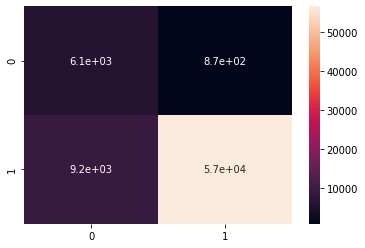

In [35]:
model_test = model_load(config, 
                        BinaryBiLSTM(config.NUM_FEATURES, config.N_CLASSES).to(device),
                        name=result_name,
                       )
y_true, y_pred, y_prob = test(config, test_loader, model_test)

In [36]:
report = classification_report(y_true, y_pred)

# write the report
write_log("\n{}\n\n{}\n".\
          format("=== Classification Report ===",
                 report
                ),
          config.log_file,
          "a+")

# print
# print(report)


=== Classification Report ===

              precision    recall  f1-score   support

           0       0.40      0.88      0.55      6986
           1       0.98      0.86      0.92     65747

    accuracy                           0.86     72733
   macro avg       0.69      0.87      0.73     72733
weighted avg       0.93      0.86      0.88     72733




### 8-2. Saving Testing Result

In [37]:
config.PREDICTED_RESULT = os.path.join("result/graph/prediction", "{}.pkl".format(result_name))

In [38]:
import pickle
# saving predicted result
with open(config.PREDICTED_RESULT, 'wb') as f:
    pickle.dump([y_true, y_pred, y_prob], f)

In [39]:
with open(config.PREDICTED_RESULT, 'rb') as f:
    y_true, y_pred, y_prob = pickle.load(f)

## 9. Learning Curve

In [40]:
with open(config.log_file, "r+") as file:
    logs = file.readlines()
    val_loss = []
    train_loss = []
    for row in logs:
        if len(row.split("|")) < 2:
            continue
        else:
            train_loss.append(float(row.split("|")[-2].strip().split(" ")[-1]))
            val_loss.append(float(row.split("|")[-1].strip().split(" ")[-1]))
    assert len(train_loss) == len(val_loss)

Text(0.5, 0, 'N Batch')

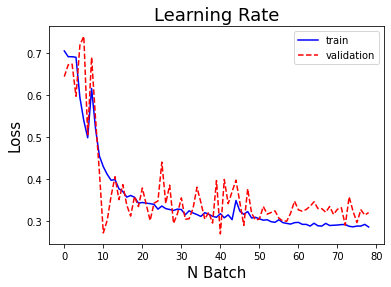

In [43]:
fig, ax = plt.subplots()
ax.plot(range(len(train_loss)), train_loss, '-b', label='train')
ax.plot(range(len(val_loss)), val_loss, '--r', label='validation')
leg = ax.legend()
plt.title("Learning Rate", fontsize=18)
plt.ylabel("Loss", fontsize=15)
plt.xlabel("N Batch", fontsize=15)

## 10. Why precision in 0 is much lower?

Transition words? e.g. but, however.

In [56]:
test_df_pred_zero = test_df[[not bool(i) for i in y_pred]] # select y_pred == 0
selected_index = list(test_df_pred_zero[test_df_pred_zero["overall"] == 3]["reviewText"].index)
np.random.seed(100)
np.random.shuffle(selected_index)
for i in range(5):
    print("Index {}:".format(selected_index[i]))
    print("Overall {}:".format(test_df_pred_zero["overall"][selected_index[i]]))
    print(test_df_pred_zero[test_df_pred_zero["overall"] == 3]["reviewText"][selected_index[i]])
    print("---"*10)

Index 48040:
Overall 3:
was not very fond  of this selection I was really tried it  1 time and  then  have not since
------------------------------
Index 39202:
Overall 3:
Motion Explosion is a compilation of 12 mini-games that have you balancing things, juggling things, grabbing things, and dodging things. In other words, it's a game whose main purpose seems to be so you can tell people, "Hey, I have a Kinect. Isn't it cool?"

To get started, you can choose a guest avatar or use yours. You can play with up to 4 players; to say it's a "four player game" is a bit misleading because you're not competing against each other at once, you're taking turns.

There are 12 mini games and each game has 10 levels of play. Here are the games:

Balance Beam. In this game, you hold a board over your head while different-shaped blocks fall on it. You have to balance them as they fall on your board and dump them into buckets to collect points. The level of control and responsiveness is very good--you c

### 8-4. Word Length

In [ ]:
# seed_torch(config.SEED)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_word_length = []
for batch in tqdm(test_loader):
#     nodes_count = sorted(Counter(batch.batch.data.numpy()).items(), key=lambda x: x[0])
    x = batch.batch.data.numpy()
    unique, counts = np.unique(x, return_counts=True)
    test_word_length += list(counts)

/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
assert len(y_prob) == len(test_word_length)
with open(os.path.join("dataset/token_length/", "testloader_reviews_seed_{}.pkl".format(config.SEED)), 'wb') as f:
    pickle.dump(test_word_length, f)

In [ ]:
with open(os.path.join("dataset/token_length/", "testloader_reviews_seed_{}.pkl".format(config.SEED)), 'rb') as f:
    test_word_length_reloaded = pickle.load(f)

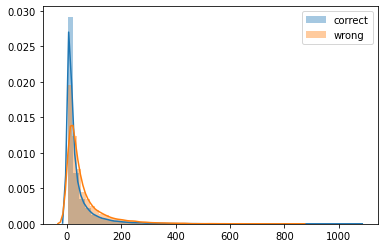

In [75]:
compared_result = [y_pred[i] == y_true[i] for i in range(len(y_true))]
correct_word_length = [test_word_length_reloaded[idx] for idx, value in enumerate(compared_result) if value == True] # the word length list of the sample which is predicted correctly
wrong_word_length = [test_word_length_reloaded[idx] for idx, value in enumerate(compared_result) if value == False]
sns.distplot(correct_word_length, hist=True)
sns.distplot(wrong_word_length, hist=True)
plt.legend(labels=["correct", "wrong"])

## 11. Score in 5 Group vs. Accuracy

I am interested in the prediction of the review with an original overall score from 1 to 5.

In [49]:
def score_5_acc(score, labels, compared_result):
    labels = list(labels)
    selected_comared_result = [res for idx, res in enumerate(compared_result) if labels[idx] == score]
    return round(sum(selected_comared_result) / len(selected_comared_result)*100, 2)

compared_result = [y_pred[i] == y_true[i] for i in range(len(y_true))]
for i in range(1, 6):
    print("Overall Score {}: {}%".format(i, score_5_acc(score=i,
                                                         labels=test_df["overall"],
                                                         compared_result=compared_result)))

Overall Score 1: 92.19%
Overall Score 2: 81.9%
Overall Score 3: 49.67%
Overall Score 4: 81.58%
Overall Score 5: 92.31%


## Retrain

In [36]:
model_train = model_load(config, 
                        BinaryBiLSTM(config.NUM_FEATURES, config.N_CLASSES).to(device),
                        name=result_name,
                       )

In [ ]:
''' initials '''
# seed_torch(config.SEED)
seed_torch(config.SEED)
config.N_CLASSES = 1
model_name = "BiLSTM"
config.max_len = 134
config.lr = 0.002401

''' rebuild dataset and dataloader due to edge_index '''
train_dataset = ReviewDataset(config,
                       df=train_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=config.max_len),
                       )
val_dataset = ReviewDataset(config,
                       df=val_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=config.max_len),
                       )
test_dataset = ReviewDataset(config,
                       df=test_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=config.max_len),
                       )

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

''' initializing the model '''
model = model_train
criterion = nn.BCEWithLogitsLoss().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=config.lr)

# config.best_model = os.path.join(config.result_path, "checkpoint/{}_{}.pth".format(model_name,
#                                                                                    datetime.now().strftime("%Y_%m_%d_%H_%M")
#                                                                                   )
#                                 )
# config.log_file = os.path.join(config.log_path, "{}_{}.txt".format(model_name,
#                                                                               datetime.now().strftime("%Y_%m_%d_%H_%M")
#                                                                             )
#                               )
''' start training '''
saved = True
if 1 == 1:  # change to True to train
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = float("inf")
    init = datetime.now()
    config.epochs = 15
    config.log_every = 500
    config.n_bad_loss = 4

    if saved:
        output_text = write_config(config) + "Start record at {}\n".format(str(datetime.now()))
        write_log(output_text,
                  config.log_file,
                  "a+")
        
    for epoch in range(1, config.epochs+1):
        train(config, train_loader, val_loader, model, criterion, optimizer)
        if stop:
            break

=== Settings ===
batch_size: 64
seed: 5
epochs: 15
cuda: True
log_every: 500
lr: 0.002401
lr_decay: 0.7
lr_min: 1e-05
n_bad_loss: 4
clip: 2.3
result_path: result/sequence/
log_path: logs/sequence/
USE_CUDA: True
SEED: 123
MODELING_FEATURE_PATH: dataset/full_dataset/modeling_features.json
DATA_PATH: dataset/processed_dataset/
NUM_FEATURES: 768
N_CLASSES: 1
TARGET: y
TOKENS: reviewTokens
best_model: result/sequence/checkpoint/BiLSTM_2020_08_24_14_05.pth
log_file: logs/sequence/BiLSTM_2020_08_24_14_05.txt
max_len: 134

Start record at 2020-08-25 12:14:08.307603

=> EPOCH 1


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


   % Time: 0:23:42.458585 | Iteration:   500 | Batch:  500/1743 | Train loss: 0.3488 | Val loss: 0.3974
   % Time: 0:45:05.830015 | Iteration:  1000 | Batch: 1000/1743 | Train loss: 0.3232 | Val loss: 0.3438
   % Time: 1:06:18.683537 | Iteration:  1500 | Batch: 1500/1743 | Train loss: 0.3158 | Val loss: 0.2893

=> EPOCH 2


   % Time: 1:27:35.816035 | Iteration:  2000 | Batch:  257/1743 | Train loss: 0.3224 | Val loss: 0.3766
   % Time: 1:48:48.287521 | Iteration:  2500 | Batch:  757/1743 | Train loss: 0.3070 | Val loss: 0.3185
   % Time: 2:09:58.484600 | Iteration:  3000 | Batch: 1257/1743 | Train loss: 0.3087 | Val loss: 0.3021

=> EPOCH 3


   % Time: 2:31:01.515445 | Iteration:  3500 | Batch:   14/1743 | Train loss: 0.3050 | Val loss: 0.3045
=> Adjust learning rate to: 0.0016806999999999998
   % Time: 2:52:12.099099 | Iteration:  4000 | Batch:  514/1743 | Train loss: 0.3018 | Val loss: 0.3345
   % Time: 3:13:25.500017 | Iteration:  4500 | Batch: 1014/1743 | Train loss: 0.3028 | Val loss: 0.3162
   % Time: 3:34:34.059585 | Iteration:  5000 | Batch: 1514/1743 | Train loss: 0.2982 | Val loss: 0.3202

=> EPOCH 4


   % Time: 3:55:36.347047 | Iteration:  5500 | Batch:  271/1743 | Train loss: 0.2967 | Val loss: 0.3240
=> Adjust learning rate to: 0.0011764899999999999
   % Time: 4:16:38.762936 | Iteration:  6000 | Batch:  771/1743 | Train loss: 0.3029 | Val loss: 0.3066
   % Time: 4:37:40.508055 | Iteration:  6500 | Batch: 1271/1743 | Train loss: 0.2960 | Val loss: 0.2999

=> EPOCH 5


   % Time: 4:58:52.807313 | Iteration:  7000 | Batch:   28/1743 | Train loss: 0.2941 | Val loss: 0.2994
   % Time: 5:19:59.460460 | Iteration:  7500 | Batch:  528/1743 | Train loss: 0.2925 | Val loss: 0.3186
   % Time: 5:41:21.630200 | Iteration:  8000 | Batch: 1028/1743 | Train loss: 0.2959 | Val loss: 0.3472
   % Time: 6:02:27.349743 | Iteration:  8500 | Batch: 1528/1743 | Train loss: 0.2966 | Val loss: 0.3263

=> EPOCH 6


   % Time: 6:23:35.461010 | Iteration:  9000 | Batch:  285/1743 | Train loss: 0.2918 | Val loss: 0.3233
=> Adjust learning rate to: 0.0008235429999999998
   % Time: 6:44:50.223882 | Iteration:  9500 | Batch:  785/1743 | Train loss: 0.2918 | Val loss: 0.3274
   % Time: 7:06:02.659010 | Iteration: 10000 | Batch: 1285/1743 | Train loss: 0.2877 | Val loss: 0.3350

=> EPOCH 7


   % Time: 7:27:14.231205 | Iteration: 10500 | Batch:   42/1743 | Train loss: 0.2945 | Val loss: 0.3458
   % Time: 7:48:58.299620 | Iteration: 11000 | Batch:  542/1743 | Train loss: 0.2884 | Val loss: 0.3296
=> Adjust learning rate to: 0.0005764800999999998
